# Machine Learning: Homework 3 - Jose Vazquez-Espinoza

Algorithm's implementation in: https://github.com/

## Part 1:

EM as a minorization algorithm (Hunter and Lange, 2004; Wu and Lange, 2007). A function $g(x,y)$ to said to minorize a function $f(x)$ if

$$g(x,y) \leq f(x), g(x,x) = f(x)$$

for all $x, y$ in the domain. This is useful for maximizing $f(x)$ since is easy to show that $f(x)$ is non-decreasing under the update

$$x^{s+1} = argmax_x g(x,x^s)$$

There are analogous definitions for majorization, for minimizing a function $f(x)$. The resulting algorithms are known as MM algorithms, for “Minorize-Maximize” or “Majorize-Minimize.”

Show that the EM algorithm (Section 8.5.2) is an example of an MM al-gorithm, using $Q(\theta′,\theta)+\log P(Z|\theta)−Q(\theta, \theta)$ to minorize the observed data log-likelihood $l(\theta′; Z)$. (Note that only the first term involves the relevant
parameter $\theta′$).

## Part 2:

### Problem (a):
Consider a Gaussian mixture model in which the marginal distribution $p(z)$ for the latent variable is given by (9.10), and the conditional distribution $p(x|z)$ for the observed variable is given by (9.11). Show that the marginal distribution $p(x)$, obtained by summing $p(z)p(x|z)$ over all possible values of $z$, is a Gaussian
mixture of the form (9.7).

### Problem (b):
Consider a mixture distribution of the form
$$p(x) = \sum_{k=1}^K \pi_k p(\mathbf{x}|k)$$
where the elements of $x$ could be discrete or continuous or a combination of these.
Denote the mean and covariance of $p(x|k)$ by $μ_k$ and $\Sigma_k$ , respectively. Show that
the mean and covariance of the mixture distribution are given by (9.49) and (9.50).

## Part 3:

Implement using Python the EM algorithm for the mixture of Gaussians. After this:
1. Create two classes composed of k Gaussians splitting the set in

    1. 90% random training data
    2. 10% random testing data
    
    
2. Adjust the Gaussian Mixture to such classes.
3. Use naive Bayesian classification to build the Confusion Matrix of your experiments

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import random
from scipy.stats import multivariate_normal
%matplotlib inline

In [2]:
class UnivariateGaussian:
    "Univariate Gaussian"
    def __init__(self, mu, sigma):
        self.mu = float(mu)
        self.sigma = float(sigma)

    def pdf(self, datapoint):
        "Probability dennsity function of univariate gaussian/normal distribution"
        z = (datapoint - self.mu)/ abs(self.sigma)
        p_x = (1/(np.sqrt(2*self.sigma) * self.sigma))*np.exp(-z * z /2)
        return p_x

    def __repr__(self):
        return 'Gaussian({0:4.6}, {1:4.6})'.format(self.mu, self.sigma)

In [3]:
class MultivariateGaussian:
    """
    Implementation of Multivariate Gaussian Distribution
    """
    def __init__(self, mu, sigma):
        """
        Initialization of a Multivariate Gaussian distribution, we do precomputation to 
        avoid extra computation in further methods.
        :param mu: Vertical vector of the mean
        :param sigma: Covariance Matrix
        """
        self.mu = mu
        self.sigma = sigma
        self.inv_sigma = np.linalg.pinv(sigma)
        self.det_sigma = np.linalg.det(sigma)
    
    def pdf(self, x):
        """
        Estimating probability at a single point
        :param x: datapoint must be the same size as mu 
        :return: probability of this datapoint
        """
        if x.shape != (x.shape[0],1):
            x = x.reshape((x.shape[0], 1))
        
        u = (x - self.mu)
        z = - 1/2.0 * np.dot(np.dot(u.T, self.inv_sigma), u)
        norm_factor = (1/((2*np.pi)**(self.mu.shape[0]/2.0)))*(1/np.sqrt(self.det_sigma))
        p_x = norm_factor * np.exp(z)
        
        return float(p_x)

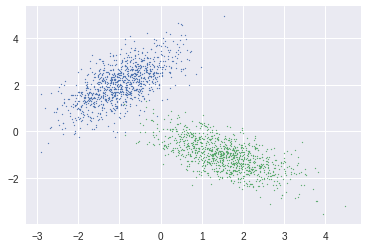

In [4]:
#Data set Initialization

std = [[0.5, 0.4], [0.4,0.7]]
std2 = [[0.7, -0.4], [-0.4,0.5]]
c1 = np.random.multivariate_normal([-1, 2], std, 1000);
c2 = np.random.multivariate_normal([1.5, -1], std2, 1000);
X = np.concatenate([c1,c2])

labels = np.ones(1000)
labels2 = -1 * np.ones(1000)
Y = np.concatenate([labels, labels2])
Y = Y.reshape((Y.shape[0], 1))

plt.scatter(c1[:,0], c1[:,1], s=1)
plt.scatter(c2[:,0], c2[:,1], s=1)
plt.show()

In [18]:
class GaussianMixture:
    """
    Model Mixture of n multivariate Gaussian Distributions
    """

    def __init__(self,
                 data,
                 clusters=2,
                 ):
        """
        Random initialization of mean vector,
        Covariance Matrix initialized with Identity Matrix
        :param data: Data used by the parameters
        :param clusters: Number of clusters to fit the data to
        :param mix: Parameter to mix the data.
        """

        self.data = data
        self.clusters = clusters
        self.dists = {}
        self.mix = {}
        self.n = self.data.shape[0]
        self.d = self.data.shape[1]
        self.log_likelihood = 0
        mins = np.min(data, axis=0)
        maxs = np.max(data, axis=0)
        for i in range(clusters):
            self.dists["dist" + str(i)] = MultivariateGaussian(random.uniform(mins, maxs).reshape(mins.shape[0], 1),
                                                               np.identity(mins.shape[0]))
            self.mix["dist" + str(i)] = 1.0/self.clusters

    def expectation(self):
        """
        Expectation Step for Gaussian Mixtures
        :return: Parameters
        """
        # Initializing dictionary to store probabilities of n clusters
        prob_z = {}
        probs = {}

        self.log_likelihood = 0
        for i in range(self.clusters):
            probs["cluster" + str(i)] = np.zeros((self.data.shape[0], 1))

        for n in range(self.data.shape[0]):

            for i in range(self.clusters):
                prob_z["cluster" + str(i)] = self.dists["dist" + str(i)].pdf(self.data[n]) * self.mix["dist" + str(i)]

            # Normalization Factor
            den = sum(prob_z.values())
            # Normalize!
            sume = 0
            for i in range(self.clusters):
                prob_z["cluster" + str(i)] /= den
                sume += prob_z["cluster" + str(i)]

            self.log_likelihood += np.log(sume)

            for i in range(self.clusters):
                probs["cluster" + str(i)][n] = prob_z["cluster" + str(i)]

        return probs

    def maximization(self,  probs):

        # Updating the means
        accu_sigma = {}

        for i in range(self.clusters):

            den = np.sum(probs["cluster" + str(i)])
            self.dists["dist" + str(i)].mu = (np.sum(probs["cluster" + str(i)] * self.data, axis=0,
                                                     keepdims=True) / den).T

            accu_sigma["cluster" + str(i)] = np.zeros((self.d, self.d))

            for j in range(self.n):
                u = self.data[j].reshape((self.d, 1)) - self.dists["dist" + str(i)].mu
                accu_sigma["cluster" + str(i)] += probs["cluster" + str(i)][j] * np.dot(u, u.T)

            self.dists["dist" + str(i)].sigma = accu_sigma["cluster" + str(i)]/den
            self.mix["dist" + str(i)] = den / self.n
            
        

In [19]:
mix = GaussianMixture(X, clusters=2)

In [53]:
mix.dists["dist1"].mu

array([[-0.93236063],
       [ 1.98323254]])

In [51]:
probs = mix.expectation()

In [52]:
mix.maximization(probs)

## Part 4:

Now, that you have the concept of k-Cross Validation and Confusion Matrix. Please using
your previous algorithms

1. Linear Regression under Gradient Descent
2. Logistic Regression under Newton-Raphson

and data sets, please divide the data sets in training, validation and testing data sets and
provide the results for your previous experiments in terms of
1. Confusion Matrix
2. Accuracy and $F_1$ score
3. ROC curves